# Problem-Specific Coordinate Generation for HyperNEAT Substrates

## Setup

The testing was done on a 16GB VRAM GPU with CUDA 12.8. VRAM usage is determined mainly by substrate and population size.

### Imports

This setup requires some dependencies, mainly TensorNEAT, JAX, numpy, matplotlib, NetworkX, scikit-learn and wandb for logging. Using a virtual environment (i.e. conda) is highly recommended. Python 3.10.18 was used in development and testing.

In [1]:
import jax
import numpy as np
import wandb
import matplotlib.pyplot as plt
from collections import defaultdict

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate

from substrate_generation.pca_coor_generator import PCAanalyzer 
from substrate_generation.pca_inv_coor_generator import InvPCAanalyzer 
from substrate_generation.sdl_coor_generator import SparseDictionaryAnalyzer
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.manual_coor_generator import ManualInputMapper
from substrate_generation.data_sampling import collect_random_policy_data, collect_trained_agent_policy_data
from evol_pipeline.brax_env import CustomBraxEnv
from evol_pipeline.custom_pipeline import CustomPipeline
from substrate_generation.hidden_layers import HiddenLayerGenerator
from utils.visualization import visualize_cppn, visualize_nn, display_plots_side_by_side
from utils.utils import save_coordinates_to_csv, setup_folder_structure
from evol_pipeline.evol_algorithm import create_evol_algorithm

A quick setup of the folder structure to avoid errors further down the line.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

### Setup Environment

[Brax environments](https://github.com/google/brax/tree/main/brax/envs) are used for this experiment through the [TensorNEAT wrapper](https://github.com/EMI-Group/tensorneat/tree/main/src/tensorneat/problem/rl).

In [3]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]

print("env_problem.input_shape: ", env_problem.input_shape)
print("env_problem.input_shape: ", env_problem.output_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-09-08 21:40:42.516136: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-08 21:40:53.395595: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

env_problem.input_shape:  (27,)
env_problem.input_shape:  (8,)


## Data Sampling

Before we can apply data-driven approaches to the task of substrate generation, some data needs to be generated. This can either be done by generating random action or actually training an agent for a short period and then sampling from its action. Both data sampling methods are used for comparison.

### Data Sampling Method 1: Trained Agent

First, we train an number of agents for a few generations on a simple substrate for the sole purpose of sampling their actions.


In [4]:
key = jax.random.PRNGKey(config["experiment"]["seed"]) # Use seed from config
num_trained_agent_sampling = config["data_sampling"]["num_agents_to_sample"]
all_trained_agent_data = []
for i in range(num_trained_agent_sampling):
    print(f"\nTraining and sampling agent #{i+1}/{num_trained_agent_sampling}")
    key, subkey = jax.random.split(key)
    trained_agent_data_run = collect_trained_agent_policy_data(
        env_problem=env_problem,
        key=subkey,
        num_steps=config["data_sampling"]["sampling_steps"],
        training_config=config["data_sampling"]["trained_agent_sampling"]
    )
    all_trained_agent_data.append(trained_agent_data_run)

combined_trained_agent_data = np.vstack(all_trained_agent_data)

print(f"Data collection complete. Combined data from {num_trained_agent_sampling} trained agents.")
print(f"Shape of each run's data: {all_trained_agent_data[0].shape}")
print(f"Shape of combined trained agents data: {combined_trained_agent_data.shape}")



Training and sampling agent #1/2

Starting Agent Training and Data Collection
Configuring and training the agent...
Query dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 33.265162s
Generation: 1, Cost time: 7279.34ms
 	fitness: valid cnt: 1000, max: 53.8789, min: -128.2836, mean: -75.5063, std: 36.6912

	node counts: max: 7, min: 5, mean: 6.06
 	conn counts: max: 7, min: 0, mean: 4.44
 	species: 20, [517, 14, 1, 91, 1, 86, 7, 2, 1, 1, 8, 3, 3, 6, 2, 1, 1, 5, 1, 249]

Generation: 2, Cost time: 7207.05ms
 	fitness: valid cnt: 1000, max: 52.7387, min: -123.0398, mean: -36.2372, std: 58.9901

	node counts: max: 8, min: 5, mean: 6.19
 	conn counts: max: 8, min: 0, mean: 3.97
 	species: 20, [143, 21, 141, 76, 135, 12, 17, 70, 24, 1, 20, 16, 13, 13, 7, 7, 6, 3, 1, 274]

Generation: 3, Cost time: 7304.96ms
 	fitness: valid cnt: 1000, max: 52.5529, min: -126.4524, mean: -5.1032, std: 62.3056

	node counts: max: 9, min: 5, mean: 6.36
 	co

2025-09-08 21:43:25.102406: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-08 21:43:25.102422: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Causal expert data collection finished.


Training and sampling agent #2/2

Starting Agent Training and Data Collection
Configuring and training the agent...
Query dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 32.940568s
Generation: 1, Cost time: 7062.92ms
 	fitness: valid cnt: 1000, max: 51.7699, min: -125.7893, mean: -74.2196, std: 38.2292

	node counts: max: 7, min: 5, mean: 6.04
 	conn counts: max: 7, min: 0, mean: 4.40
 	species: 20, [371, 152, 1, 1, 3, 53, 1, 1, 54, 6, 112, 9, 1, 1, 2, 42, 1, 1, 3, 185]

Generation: 2, Cost time: 6954.95ms
 	fitness: valid cnt: 1000, max: 55.2573, min: -122.6591, mean: -30.6399, std: 60.2927

	node counts: max: 8, min: 5, mean: 6.09
 	conn counts: max: 8, min: 0, mean: 3.95
 	species: 20, [218, 94, 27, 140, 20, 68, 29, 8, 25, 45, 33, 24, 1, 12, 10, 5, 6, 3, 1, 231]

Generation: 3, Cost time: 7168.80ms
 	fitness: valid cnt: 1000, max: 52.1565, min: -124.5308, mean: 5.1364, std: 58.6401

	n

KeyboardInterrupt: 

### Data Sampling Method 2: Random Policy

Now, we will sample data from the environment with a random action policy.

In [ ]:
key, random_key = jax.random.split(key)
num_random_sampling_steps = num_trained_agent_sampling * config["data_sampling"]["sampling_steps"]
random_data = collect_random_policy_data(env_problem, random_key, num_random_sampling_steps)

Starting data collection for 2000 steps using a random policy...
Causal data collection finished.


In [ ]:
data_sources = {
    "trained": combined_trained_agent_data,
    "random": random_data
}

generated_io_coors = defaultdict(lambda: defaultdict(dict))

## Data Analysis

Next, it's time to analyse the sampled data. The goal is to find correlations in the data which can be used to assign substrate coordinates. Again, different methods are used for comparison, namely Principal Component Analysis (PCA), Factor Analysis (FA) and Sparse Dictionary Learning (SDL). These methods will be applied to both data samples.

In this first step, the analysis methods will be used to produce input and output coordinates only. The hidden_layers are later generated.

### PCA Analysis

Principal Component Analysis (PCA) is commonly used for dimensionality reduction and using Singular Value Decomposition of the data to project it to a lower dimensional space. The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of PCA is used here.

Analyzing trained sampling data
Running PCA to find feature dimensions covering 65.0% of variance (with a hard limit of 4 dimensions)...
PCA found 2 dimensions needed for 65.0% variance.
Applying max limit. Final number of feature dimensions: 2
Added layering dimension. Final coordinate size: 3
PCA variance plot saved to: output/halfcheetah/data_analysis/pca_variance_65_trained.png
Principal component heatmap saved to: output/halfcheetah/data_analysis/pca_heatmap_65_trained.png


Analyzing trained sampling data
Running PCA to find feature dimensions covering 99.0% of variance (with a hard limit of 4 dimensions)...
PCA found 12 dimensions needed for 99.0% variance.
Applying max limit. Final number of feature dimensions: 4
Added layering dimension. Final coordinate size: 5
PCA variance plot saved to: output/halfcheetah/data_analysis/pca_variance_99_trained.png
Principal component heatmap saved to: output/halfcheetah/data_analysis/pca_heatmap_99_trained.png


Analyzing random sampling dat

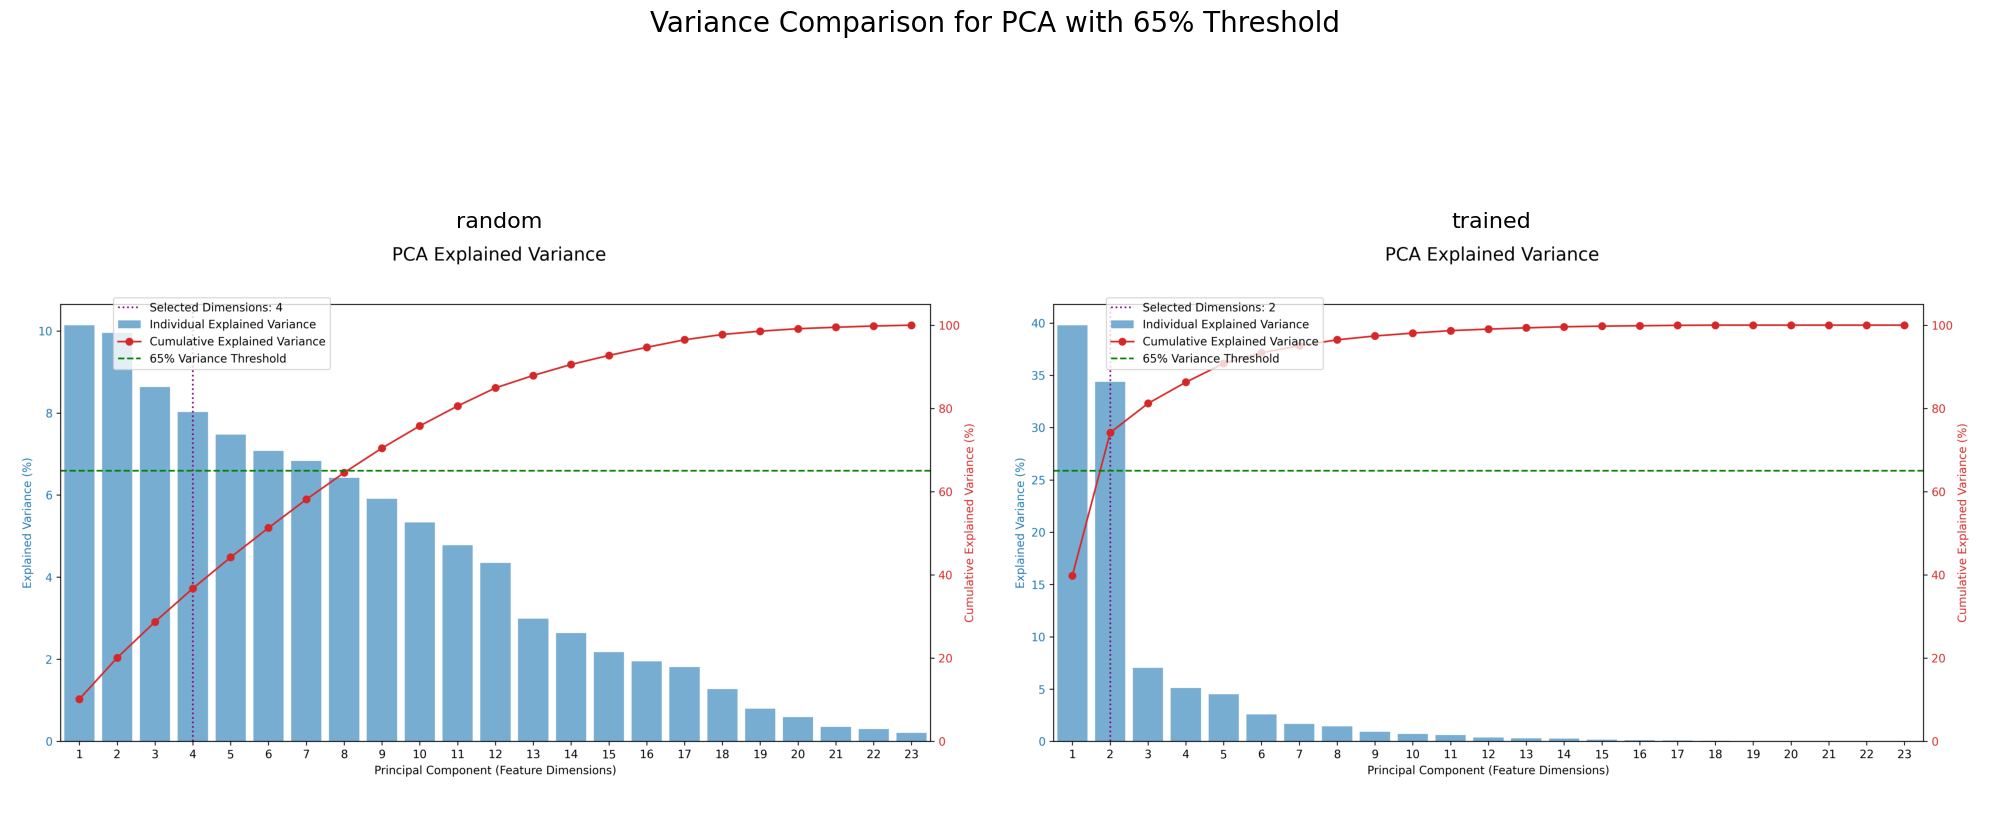

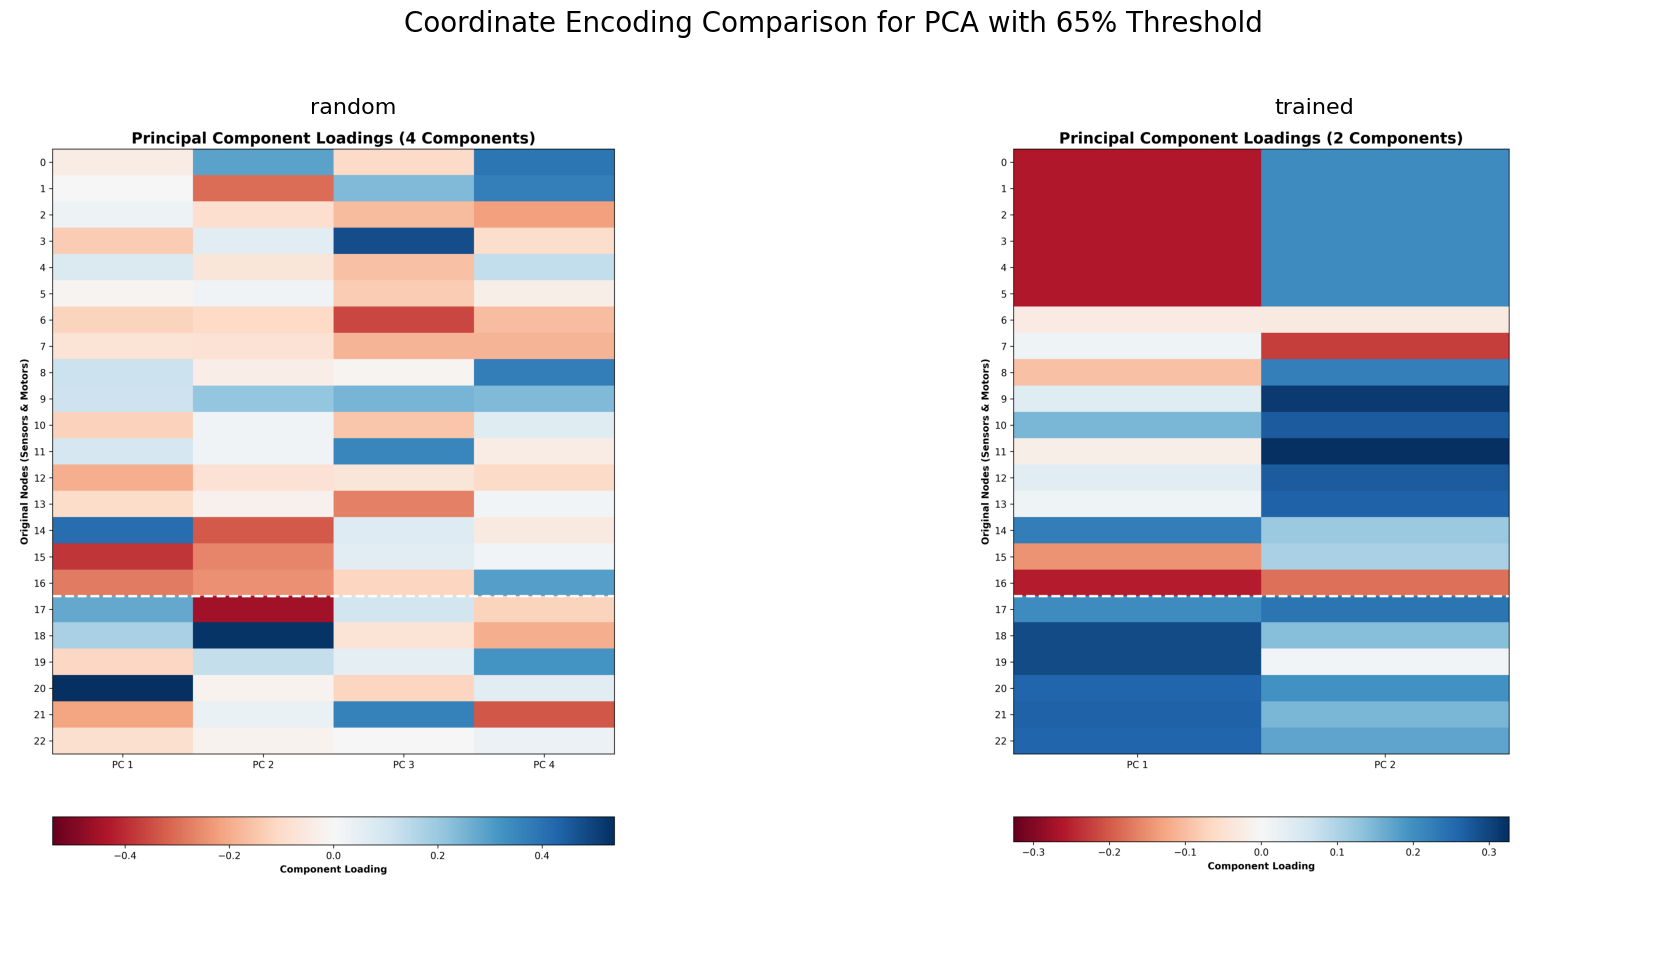

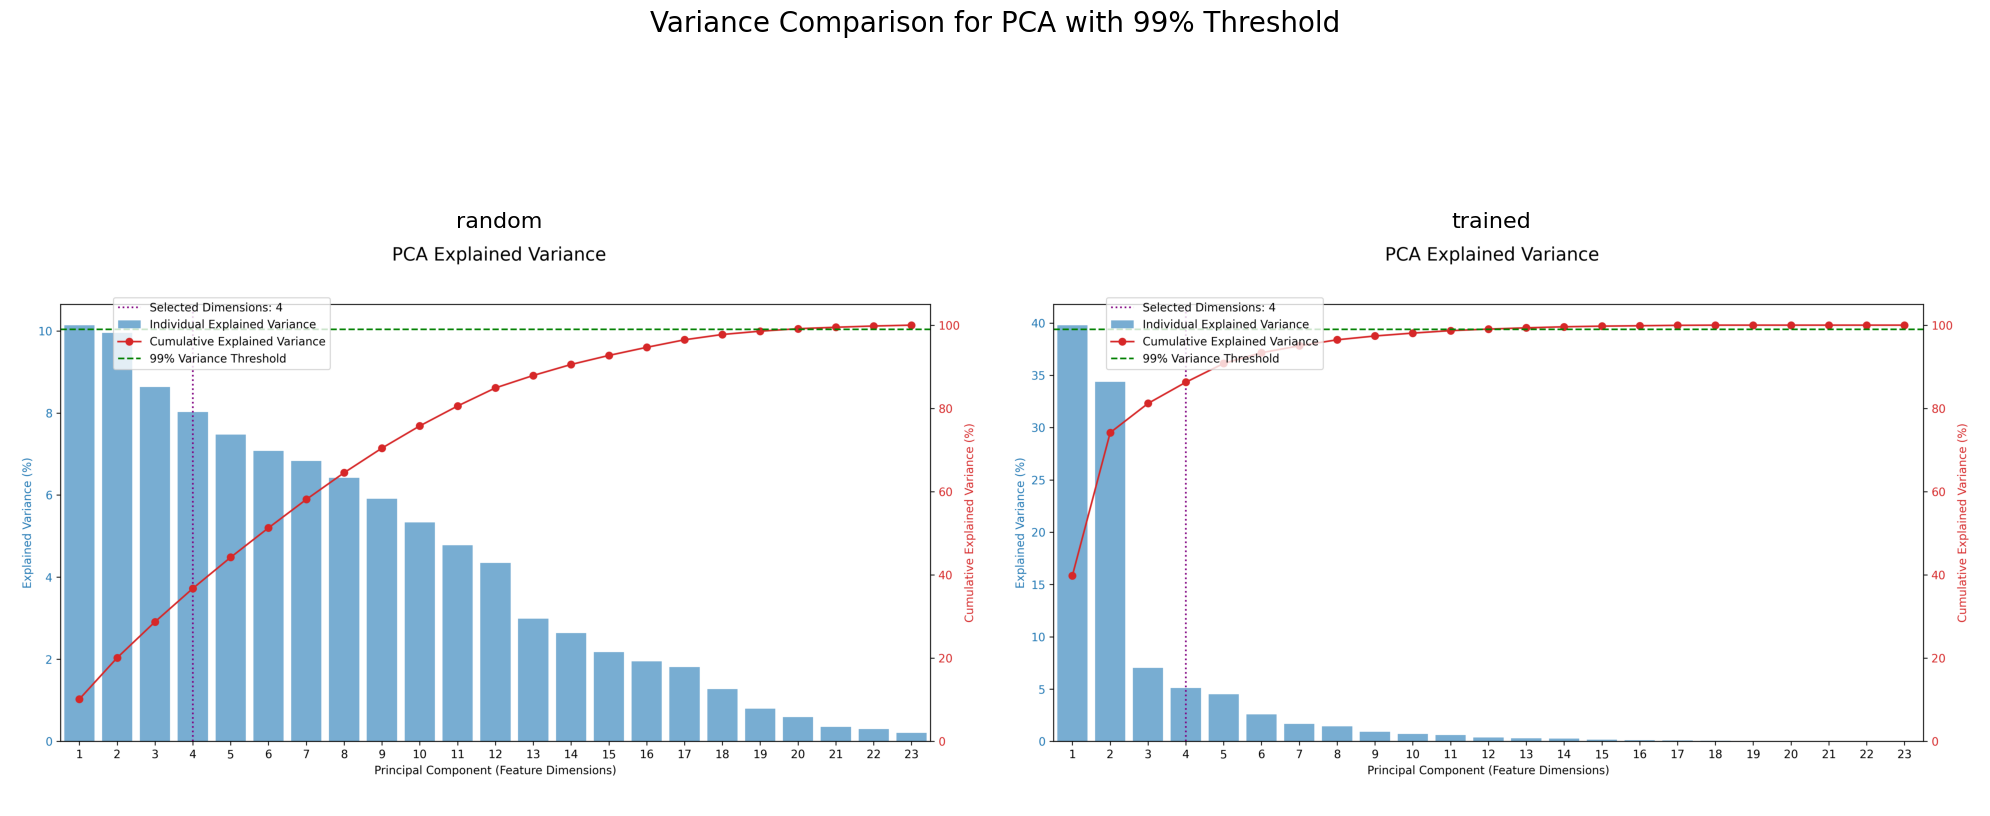

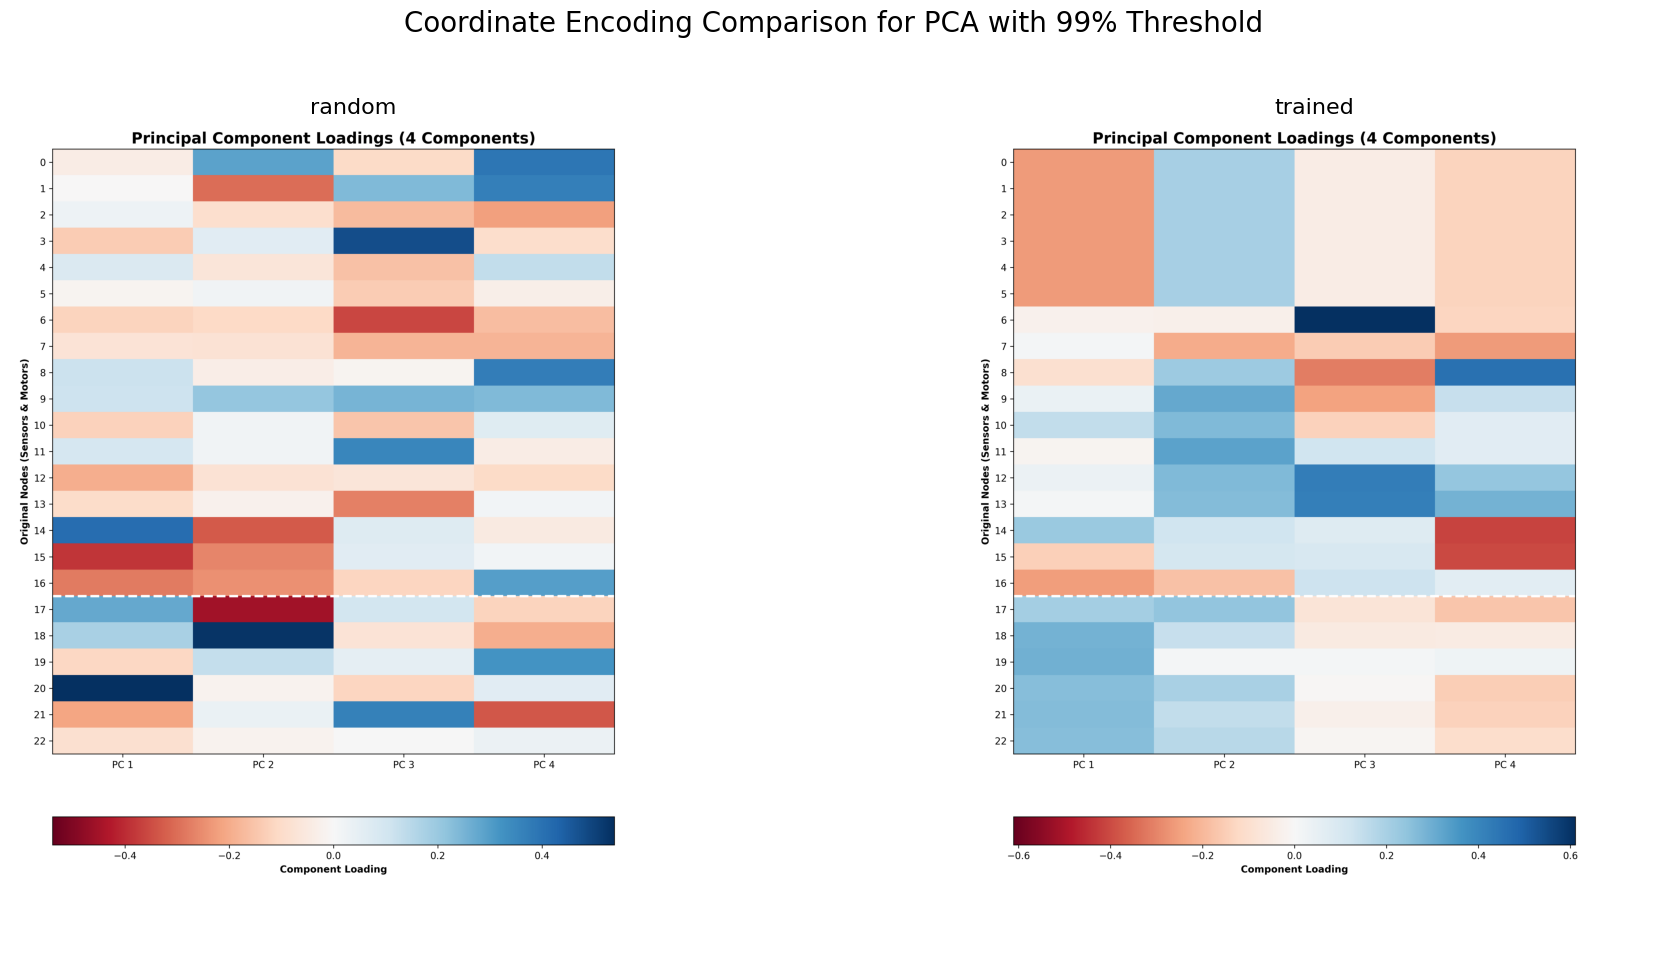

In [ ]:
pca_variances = [config["data_analysis"]["variance_threshold"], 0.99]

for data_label, data_array in data_sources.items():
    for variance in pca_variances:
        percentage = int(variance*100)
        print(f"Analyzing {data_label} sampling data")
        analyzer_pca = PCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            variance_threshold=variance, 
            max_dims=config["data_analysis"]["max_dims"](obs_size),
            hidden_depth=config["substrate"]["hidden_depth"],
            width_factor=config["substrate"]["width_factor"]
        )
        input_coors_pca, output_coors_pca = analyzer_pca.generate_io_coordinates()
        generated_io_coors[data_label][f"pca{percentage}"]["input_coors"] = input_coors_pca
        generated_io_coors[data_label][f"pca{percentage}"]["output_coors"] = output_coors_pca
        analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_{data_label}.png")
        analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_{data_label}.png")
        print("\n")

for variance in pca_variances:
    percentage = int(variance*100)
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_comparison.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_comparison.png"
)

Analyzing trained sampling data with PCA
Running inverse PCA to find 4 feature dimensions covering least variance...
Found PCs with minimum variance and added layering dimension. Final coordinate size: 5
Inverse PCA variance plot saved to: output/halfcheetah/data_analysis/inv_pca_trained.png
Principal component heatmap saved to: output/halfcheetah/data_analysis/inv_pca_heatmap_trained.png


Analyzing random sampling data with PCA
Running inverse PCA to find 4 feature dimensions covering least variance...
Found PCs with minimum variance and added layering dimension. Final coordinate size: 5
Inverse PCA variance plot saved to: output/halfcheetah/data_analysis/inv_pca_random.png
Principal component heatmap saved to: output/halfcheetah/data_analysis/inv_pca_heatmap_random.png




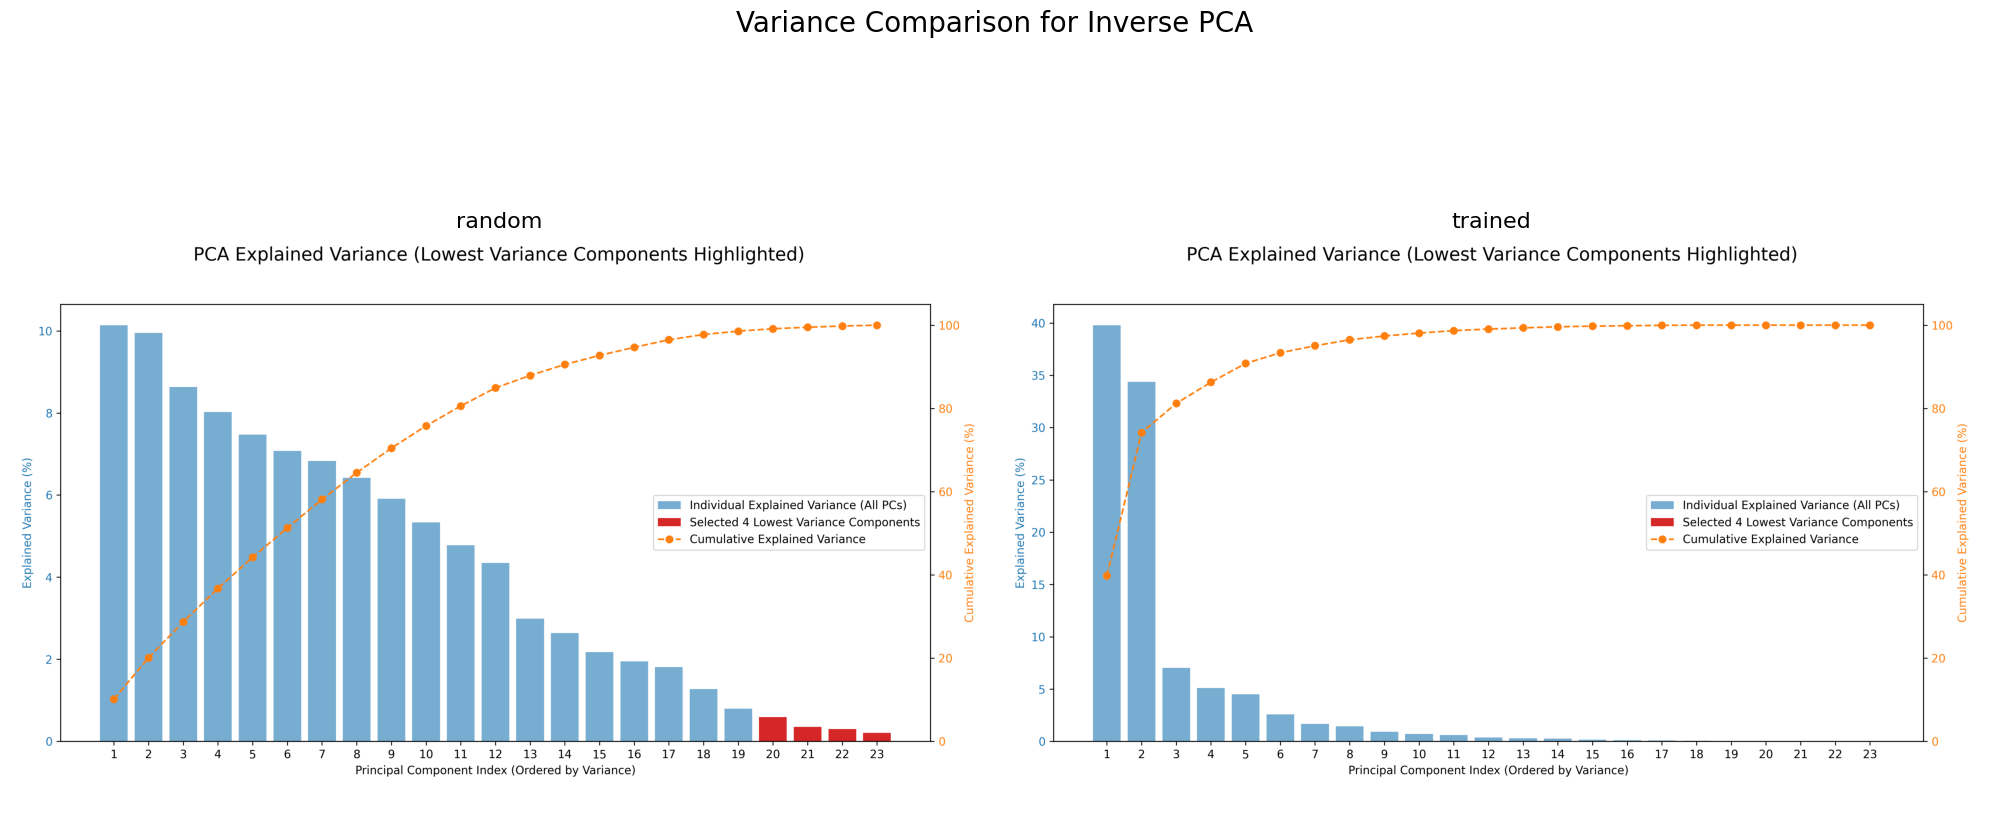

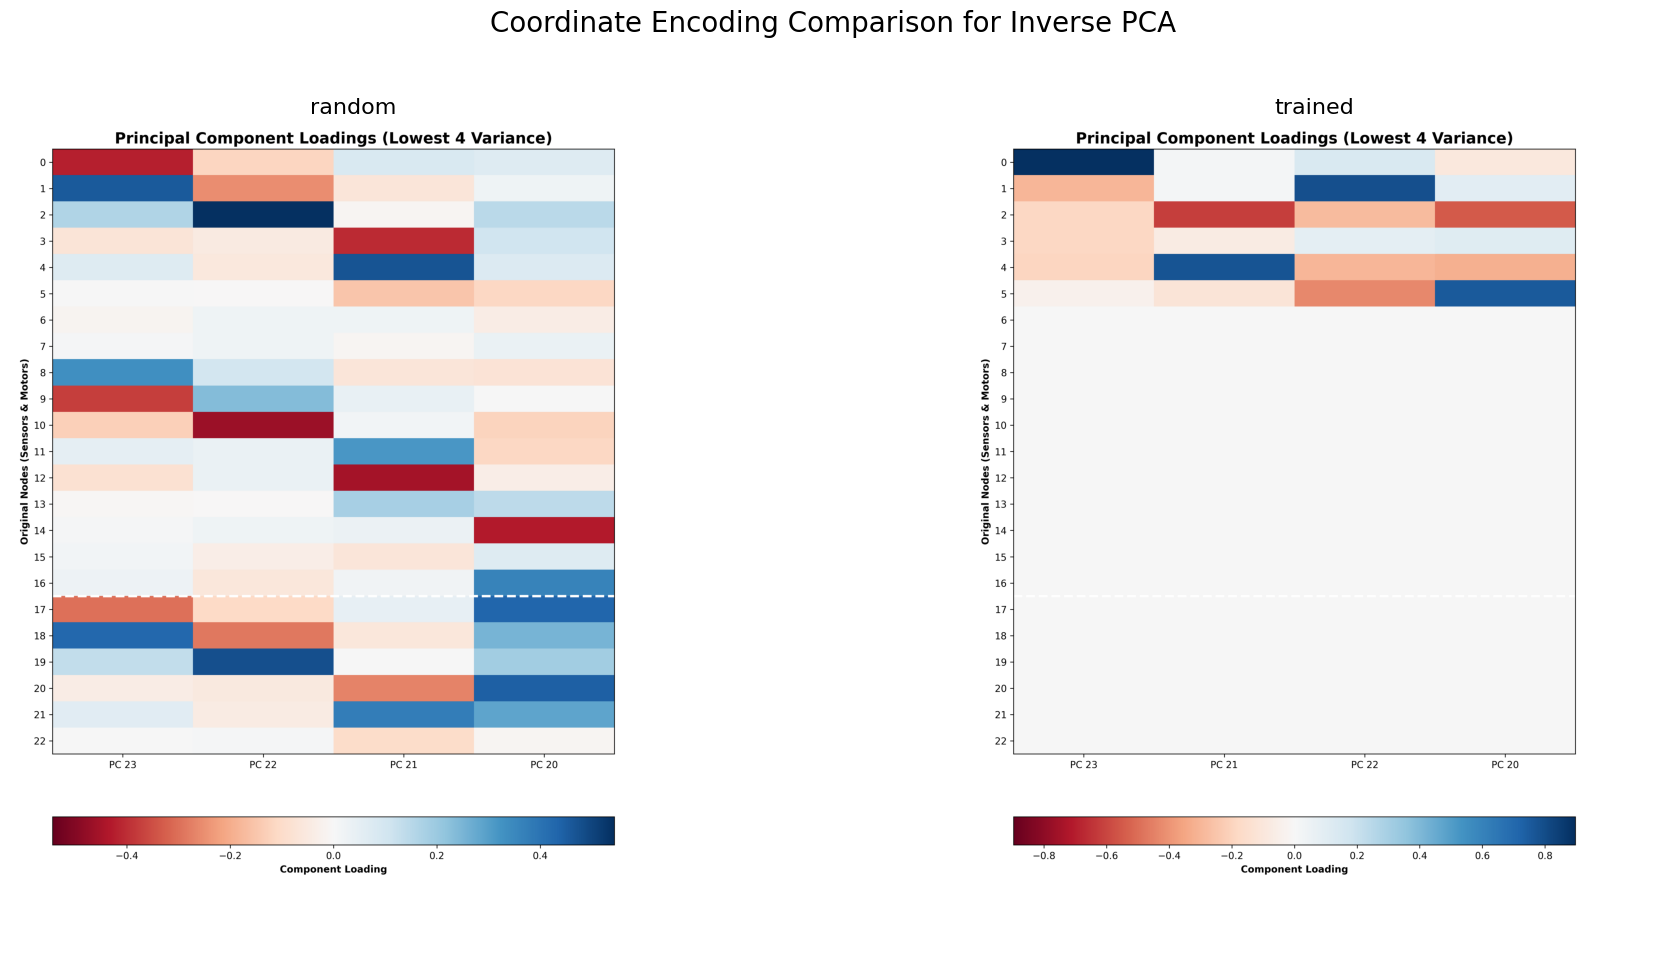

In [ ]:
for data_label, data_array in data_sources.items():
    percentage = int(variance*100)
    print(f"Analyzing {data_label} sampling data with PCA")
    analyzer_inv_pca = InvPCAanalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size),
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"]
    )
    input_coors_inv_pca, output_coors_inv_pca = analyzer_inv_pca.generate_io_coordinates()
    generated_io_coors[data_label][f"inv_pca_"]["input_coors"] = input_coors_inv_pca
    generated_io_coors[data_label][f"inv_pca_"]["output_coors"] = output_coors_inv_pca
    analyzer_inv_pca.plot_least_variance_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_{data_label}.png")
    analyzer_inv_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_{data_label}.png")
    print("\n")

percentage = int(variance*100)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Variance Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_variance_comparison.png"
)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Coordinate Encoding Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_comparison.png"
)

### Factor Analysis

Next, the data is analysed through factor analysis.

Analyzing trained sampling data
Running Factor Analysis to find 4 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 5
Factor loadings heatmap saved to: output/halfcheetah/data_analysis/fa_heatmap_trained.png


Analyzing random sampling data
Running Factor Analysis to find 4 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 5
Factor loadings heatmap saved to: output/halfcheetah/data_analysis/fa_heatmap_random.png




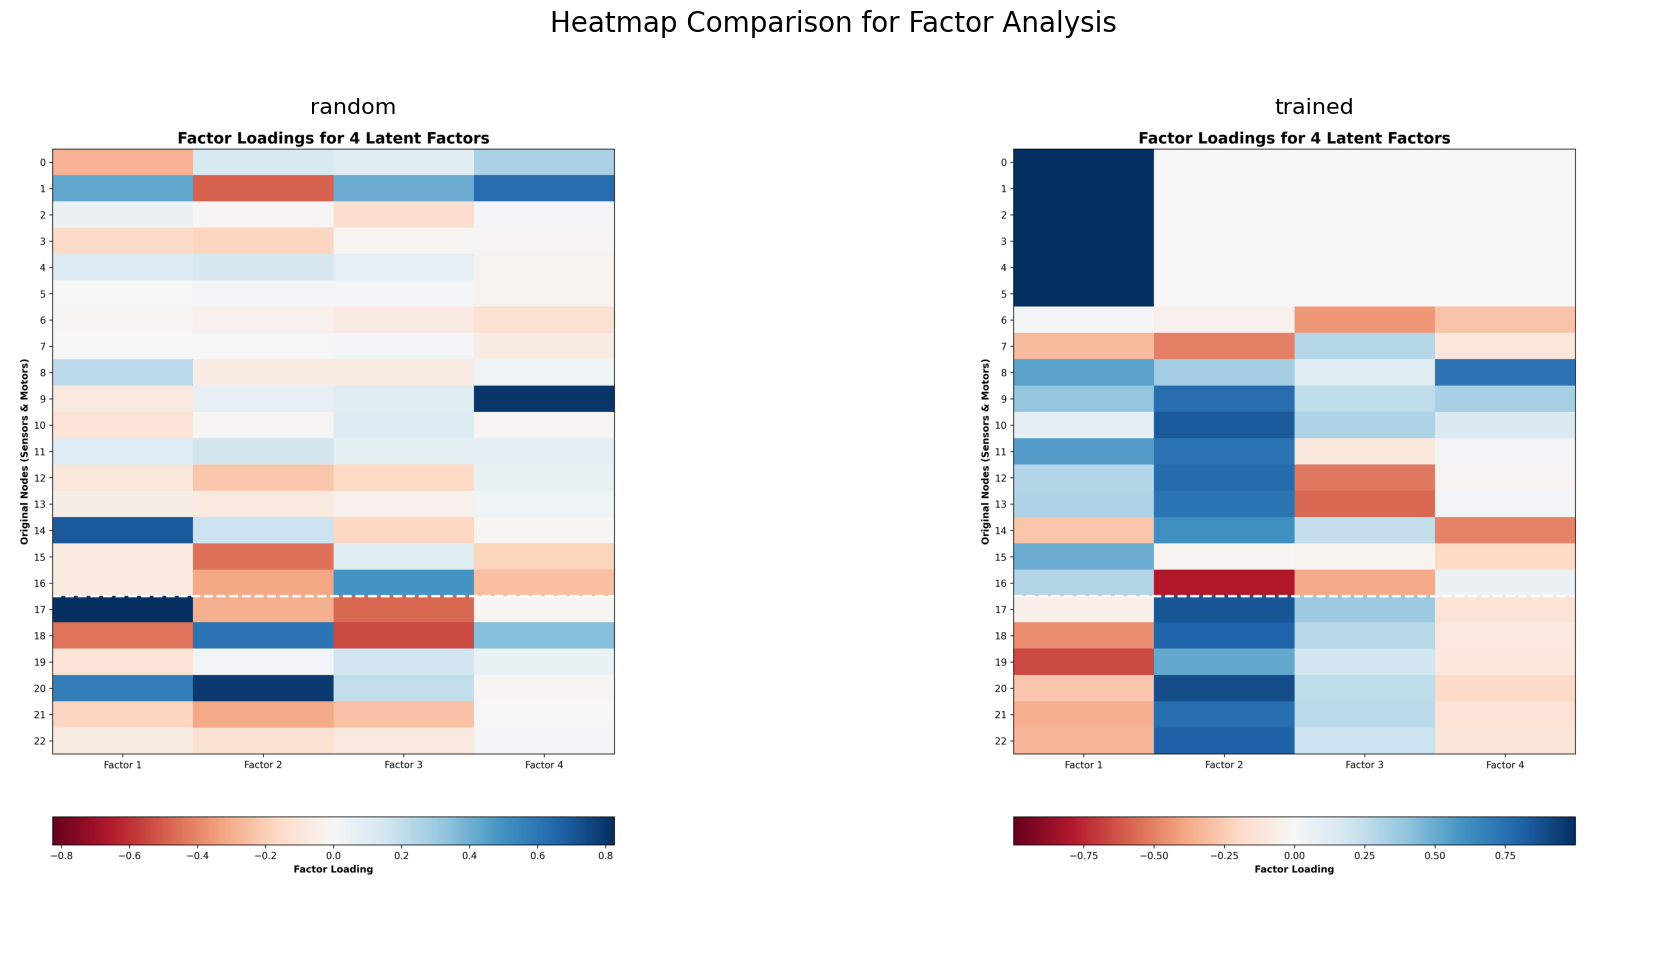

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_fa = FactorAnalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size),
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"]
    )
    input_coors_fa, output_coors_fa = analyzer_fa.generate_io_coordinates()
    generated_io_coors[data_label]["fa"]["input_coors"] = input_coors_fa
    generated_io_coors[data_label]["fa"]["output_coors"] = output_coors_fa
    analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/fa_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/fa_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for Factor Analysis",
    save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_comparison.png"
)

### Sparse Dictionary Learning

Lastly, Sparse Dictionary Learning is also applied to the data.

Analyzing trained sampling data
Running Sparse Dictionary Learning to find 4 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 5
Dictionary atoms heatmap saved to: output/halfcheetah/data_analysis/sdl_heatmap_trained.png


Analyzing random sampling data
Running Sparse Dictionary Learning to find 4 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 5
Dictionary atoms heatmap saved to: output/halfcheetah/data_analysis/sdl_heatmap_random.png




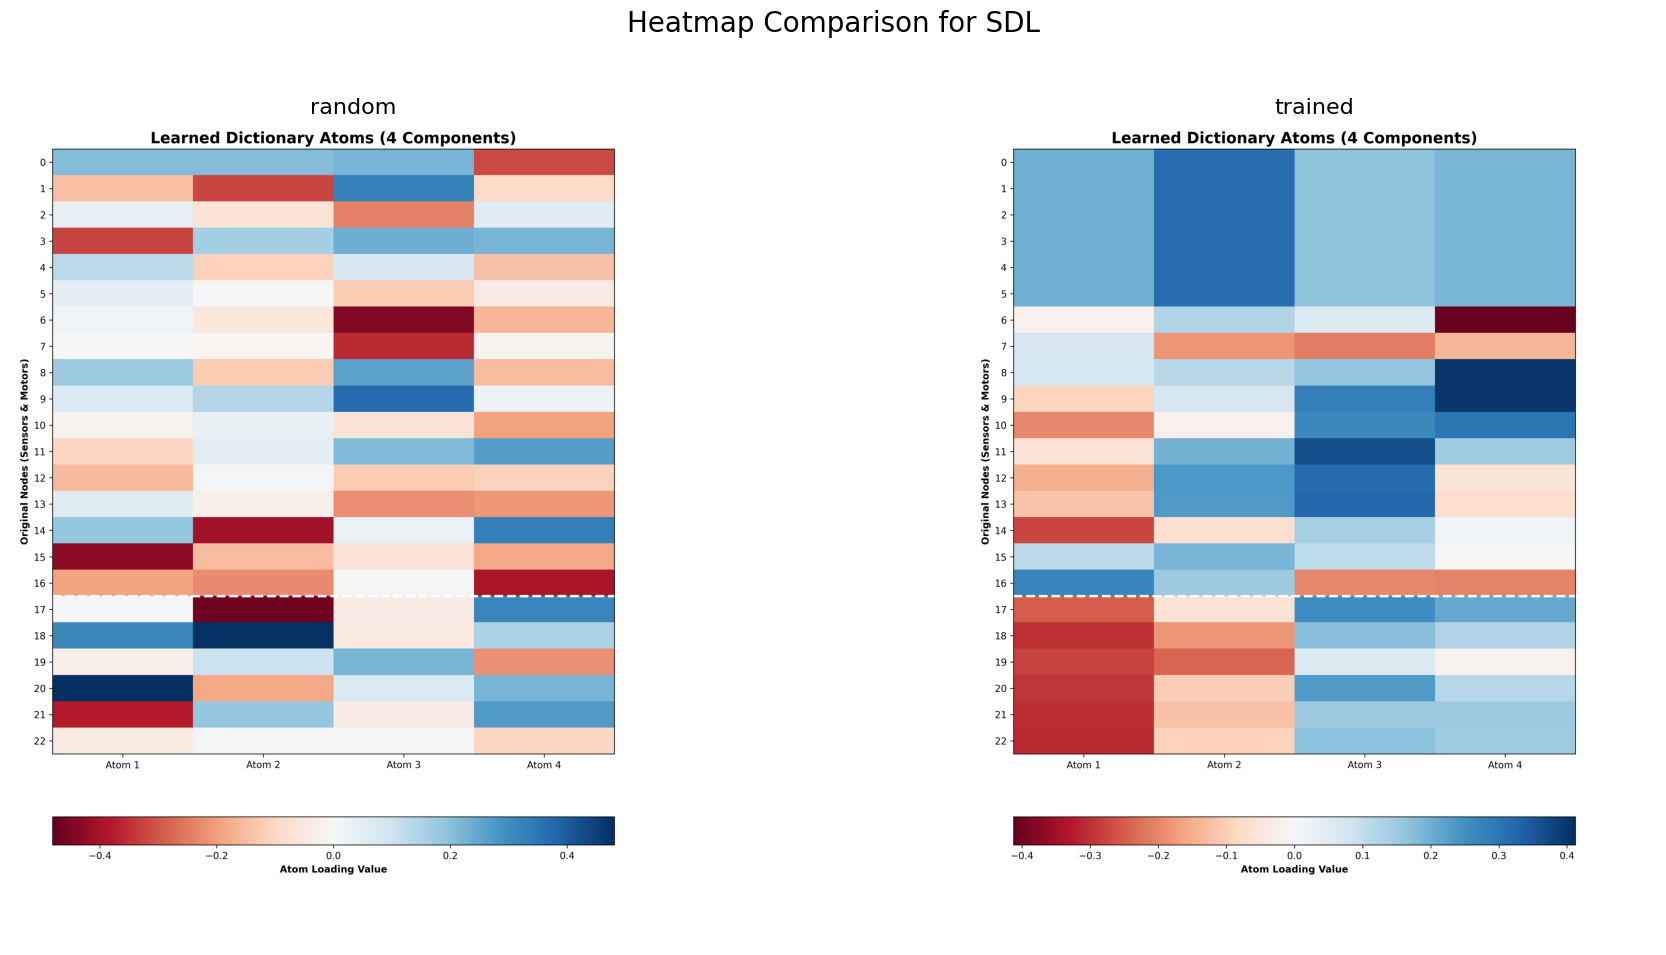

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_sdl = SparseDictionaryAnalyzer(
        data=data_array,
        obs_size=obs_size,
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size,),
        alpha=config["data_analysis"]["sdl_alpha"],
        max_iter=config["data_analysis"]["sdl_max_iter"],
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"]
    )
    input_coors_sdl, output_coors_sdl = analyzer_sdl.generate_io_coordinates()
    generated_io_coors[data_label]["sdl"]["input_coors"] = input_coors_sdl
    generated_io_coors[data_label]["sdl"]["output_coors"] = output_coors_sdl
    analyzer_sdl.plot_dictionary_atoms(save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for SDL",
    save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_comparison.png"
)

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_double_hot`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.
* `shift_two`: This does the same as `shift`, but doubles the number of nodes by adding duplicates where all the directions are multiplied by 2. This is like treating it as a vector and simply doubling it.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift` method.

In [ ]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
)

substrates = defaultdict(lambda: defaultdict(dict))

### Simple Baseline Substrates

Before the data-driven approchaes are applied, some baselines are needed. The first one is a very simple 2D grid. This is the basic baseline in the sense of a "vanilla" HyperNEAT algorithm.

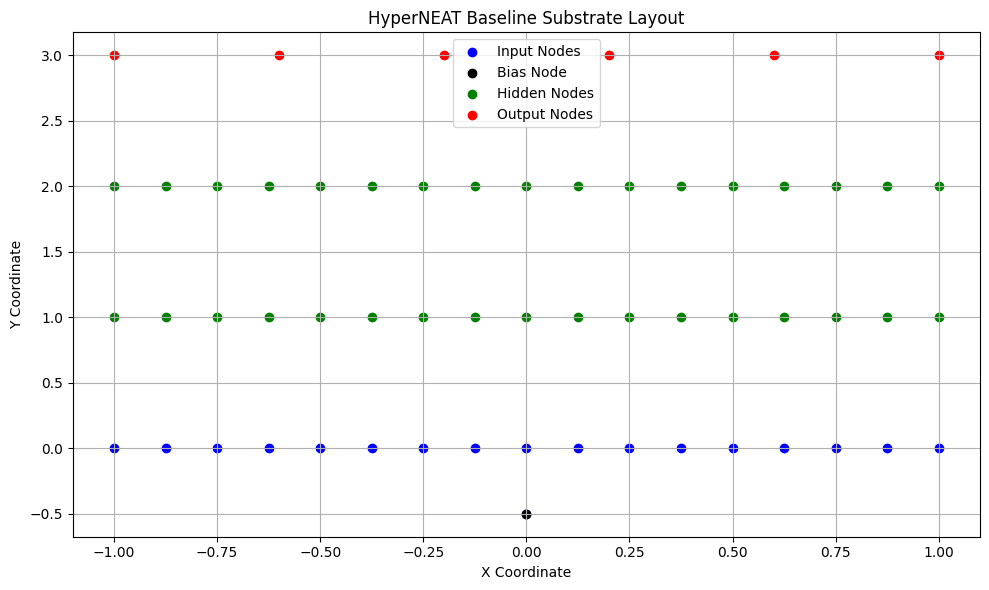

In [ ]:
hidden_width = obs_size
hidden_depth = config["substrate"]["hidden_depth"]

# Input neurons spaced horizontally from -1 to 1 at y = 0
input_coors_simple_wo_bias = [(i / (obs_size - 1) * 2 - 1, 0) for i in range(obs_size)]

# Bias node placed slightly below input layer for distinctiveness
bias_coor_simple = [(0, -0.5)]

# Hidden neurons spaced out evenly between input and output
hidden_coors_simple = [
    ((i / (hidden_width - 1) * 2 - 1), (j / max(1,(hidden_depth - 1)) * (hidden_depth - 1) + 1.0))
    for j in range(hidden_depth)
    for i in range(hidden_width)
]

# Output neurons spaced out evenly horizontally above (y =+ 1) hidden neurons
output_coors_simple = [(i / (act_size - 1) * 2 - 1, (hidden_depth+1)) for i in range(act_size)]

input_coors_simple = input_coors_simple_wo_bias + bias_coor_simple

substrates["manual"]["simple"]["substrate"] = FullSubstrate(
    input_coors=input_coors_simple,
    hidden_coors=hidden_coors_simple,
    output_coors=output_coors_simple,
)

substrates["manual"]["simple"]["input_coors"] = input_coors_simple
substrates["manual"]["simple"]["hidden_coors"] = hidden_coors_simple
substrates["manual"]["simple"]["output_coors"] = output_coors_simple

plt.figure(figsize=(10, 6))

# Plot each layer with different colors
x, y = zip(*input_coors_simple)
plt.scatter(x, y, c='blue', label='Input Nodes')
x, y = zip(*bias_coor_simple)
plt.scatter(x, y, c='black', label='Bias Node')
x, y = zip(*hidden_coors_simple)
plt.scatter(x, y, c='green', label='Hidden Nodes')
x, y = zip(*output_coors_simple)
plt.scatter(x, y, c='red', label='Output Nodes')

plt.title('HyperNEAT Baseline Substrate Layout')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/baseline_substrate")
plt.show()

### Substrate from Manual Mapping

The next baseline represents a substrate which is "hand-crafted" by a human expert.

A `ManualInputMapper` class creates substrate coordinates from a mapping of semantically meaningful categories such as "front", "back", "velocity", "angle". Every substrate node can be sorted into multiple categories. One of multiple categories form a dimension. E.g. "angle" might be a single dimension on its own whereas "front" and "back" are two opposite directions in the same dimension. Accordingly every category maps to a vector in the respective dimension. Applying all the vectors for a node, e.g. "front", "left", "hip" and "angular velocity" for the input node "angular velocity of the front left hip", generates the coordinate (0, 0, 1, 0, 0, 0, 0, -1, 1, 1, 0, 0).

The manual mappings are are implemented for the following [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [ ]:
manual_mapper = ManualInputMapper(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
    width_factor=config["substrate"]["width_factor"]
)
input_coors_manual, output_coors_manual = manual_mapper.generate_io_coordinates()
generated_io_coors["manual"]["mapping"]["input_coors"] = input_coors_manual
generated_io_coors["manual"]["mapping"]["output_coors"] = output_coors_manual

Using user-defined input and output mapping for 'halfcheetah'.
Number of feature dimensions: 5
Total number after adding output and layering dimensions (coord_size): 7
Number of input nodes (obs + bias): 18
Number of output nodes: 6


### Substrate from Data Analysis Results

Next, the input and output nodes created through data analysis are used to create substrates.

In [ ]:
for data_label, data_dict in generated_io_coors.items():
    for method_label, method_dict in data_dict.items():

        input_coors = method_dict["input_coors"]
        output_coors = method_dict["output_coors"]
        hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)
        generated_io_coors[data_label][method_label]["hidden_coors"] = hidden_coors

        substrates[data_label][method_label]["substrate"] = FullSubstrate(
            input_coors=input_coors,
            hidden_coors=hidden_coors,
            output_coors=output_coors,
        )

        substrates[data_label][method_label]["input_coors"] = input_coors
        substrates[data_label][method_label]["hidden_coors"] = hidden_coors
        substrates[data_label][method_label]["output_coors"] = output_coors

        # all input and output coordinates are logged for further analysis
        log_coors = method_dict["input_coors"]
        for coor in method_dict["output_coors"]:
            log_coors.append(coor)
        save_coordinates_to_csv(
            coordinates=log_coors,
            filepath=f"{OUTPUT_DIR}/coordinates/{data_label}_{method_label}_io.csv",
        )

Successfully saved coordinates to: output/halfcheetah/coordinates/trained_pca65_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/trained_pca99_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/trained_inv_pca__io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/trained_fa_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/trained_sdl_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/random_pca65_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/random_pca99_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/random_inv_pca__io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/random_fa_io.csv
Successfully saved coordinates to: output/halfcheetah/coordinates/random_sdl_io.csv


## Neuroevolution

Finally the substrates are ready to be used for neuroevolution.


wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


initializing
initializing finished
start compile
compile finished, cost time: 33.486791s
Generation: 1, Cost time: 19015.13ms
 	fitness: valid cnt: 600, max: 1910.8594, min: -2294.6802, mean: -239.2747, std: 375.0926

	node counts: max: 7, min: 5, mean: 6.08
 	conn counts: max: 7, min: 0, mean: 4.49
 	species: 15, [148, 177, 5, 5, 1, 1, 60, 1, 20, 1, 1, 11, 4, 36, 129]

Generation: 2, Cost time: 18967.47ms
 	fitness: valid cnt: 600, max: 2936.7871, min: -1292.3295, mean: -65.3154, std: 485.5645

	node counts: max: 8, min: 5, mean: 6.24
 	conn counts: max: 8, min: 0, mean: 4.17
 	species: 15, [32, 88, 29, 36, 23, 20, 36, 11, 71, 11, 9, 12, 9, 35, 178]

Generation: 3, Cost time: 18981.40ms
 	fitness: valid cnt: 600, max: 4892.6133, min: -1548.6021, mean: 167.4469, std: 738.5021

	node counts: max: 9, min: 5, mean: 6.20
 	conn counts: max: 8, min: 0, mean: 3.72
 	species: 15, [17, 31, 37, 33, 30, 28, 80, 14, 33, 11, 22, 17, 19, 43, 185]

Generation: 4, Cost time: 18989.33ms
 	fitness: val

Total reward:  6337.675


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/halfcheetah/video/agent_manual_simple.mp4
Visualizing CPPN. Saving to output/halfcheetah/topology/cppn_manual_simple.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 1972 potential connections.
Visualizing 1267 connections. Excluded loops. Weight threshold: 0.1


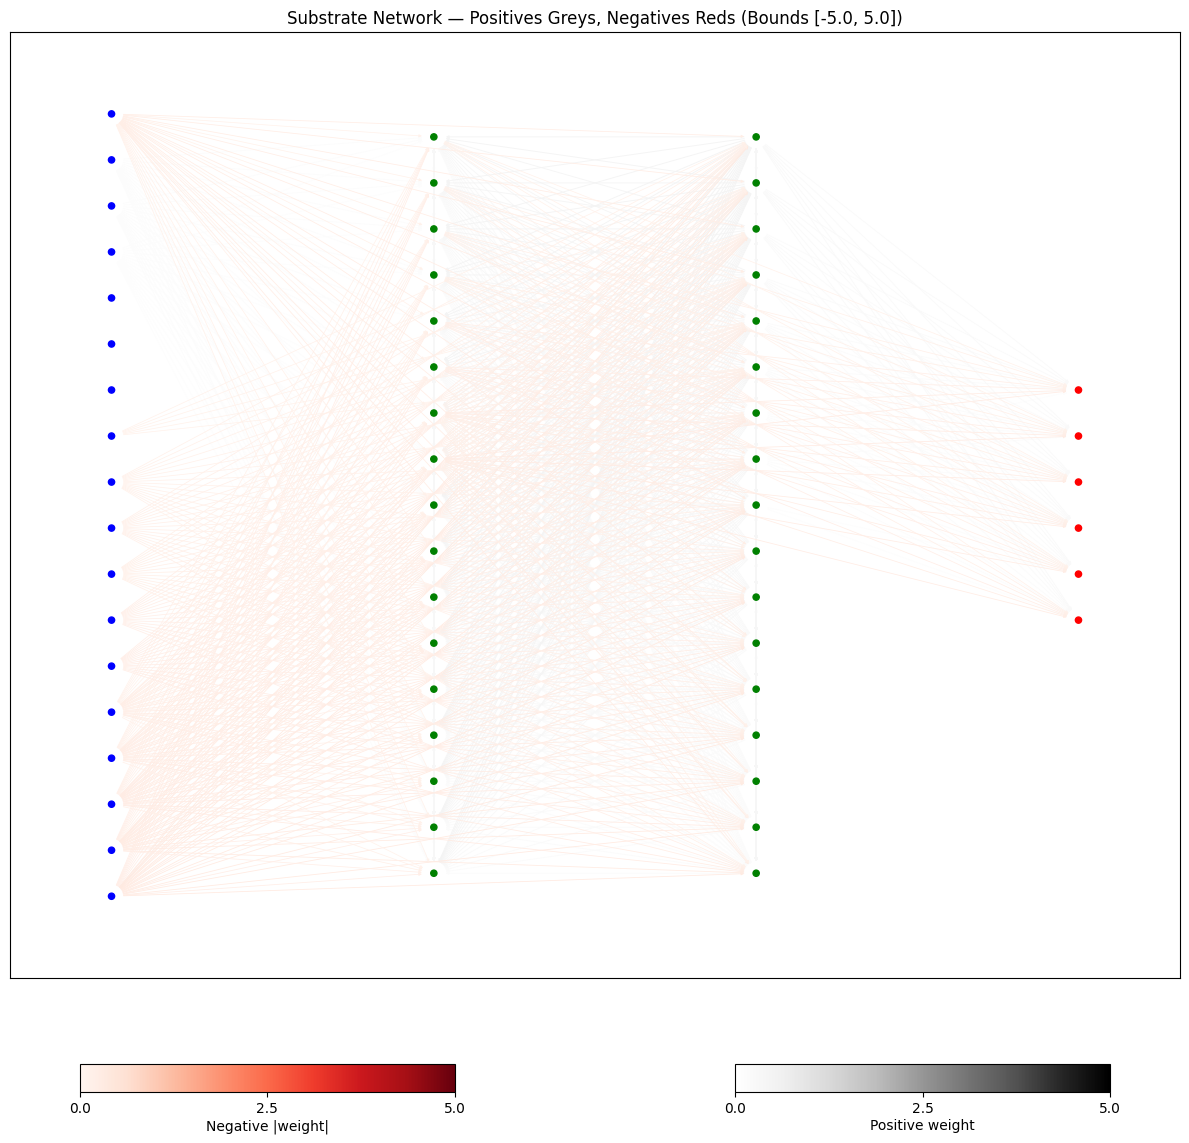

Visualization saved to: output/halfcheetah/topology/nn_manual_simple.svg


initializing
initializing finished
start compile
compile finished, cost time: 33.230584s
Generation: 1, Cost time: 19593.92ms
 	fitness: valid cnt: 600, max: 4405.4961, min: -3810.1724, mean: -260.5982, std: 571.2036

	node counts: max: 19, min: 17, mean: 18.08
 	conn counts: max: 47, min: 29, mean: 43.03
 	species: 15, [225, 11, 33, 22, 23, 45, 18, 27, 7, 5, 16, 101, 22, 27, 18]

Generation: 2, Cost time: 19572.43ms
 	fitness: valid cnt: 600, max: 4063.2800, min: -3903.0085, mean: 10.8822, std: 793.4365

	node counts: max: 20, min: 16, mean: 17.98
 	conn counts: max: 48, min: 14, mean: 40.18
 	species: 15, [9, 32, 11, 23, 84, 30, 45, 25, 3, 4, 30, 16, 79, 44, 165]

Generation: 3, Cost time: 19577.02ms
 	fitness: valid cnt: 600, max: 4173.5181, min: -3939.6367, mean: 621.8423, std: 968.9031

	node counts: max: 20, min: 16, mean: 18.02
 	conn counts: max: 48, min: 14, mean: 39.57
 	species: 15, [63, 24, 78, 45, 43, 27, 21, 23, 43, 30, 39, 24, 66, 27, 47]

Generation: 4, Cost time: 19577

Total reward:  4008.0413


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/halfcheetah/video/agent_manual_mapping.mp4
Visualizing CPPN. Saving to output/halfcheetah/topology/cppn_manual_mapping.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 3456 potential connections.
Visualizing 2496 connections. Excluded loops. Weight threshold: 0.1


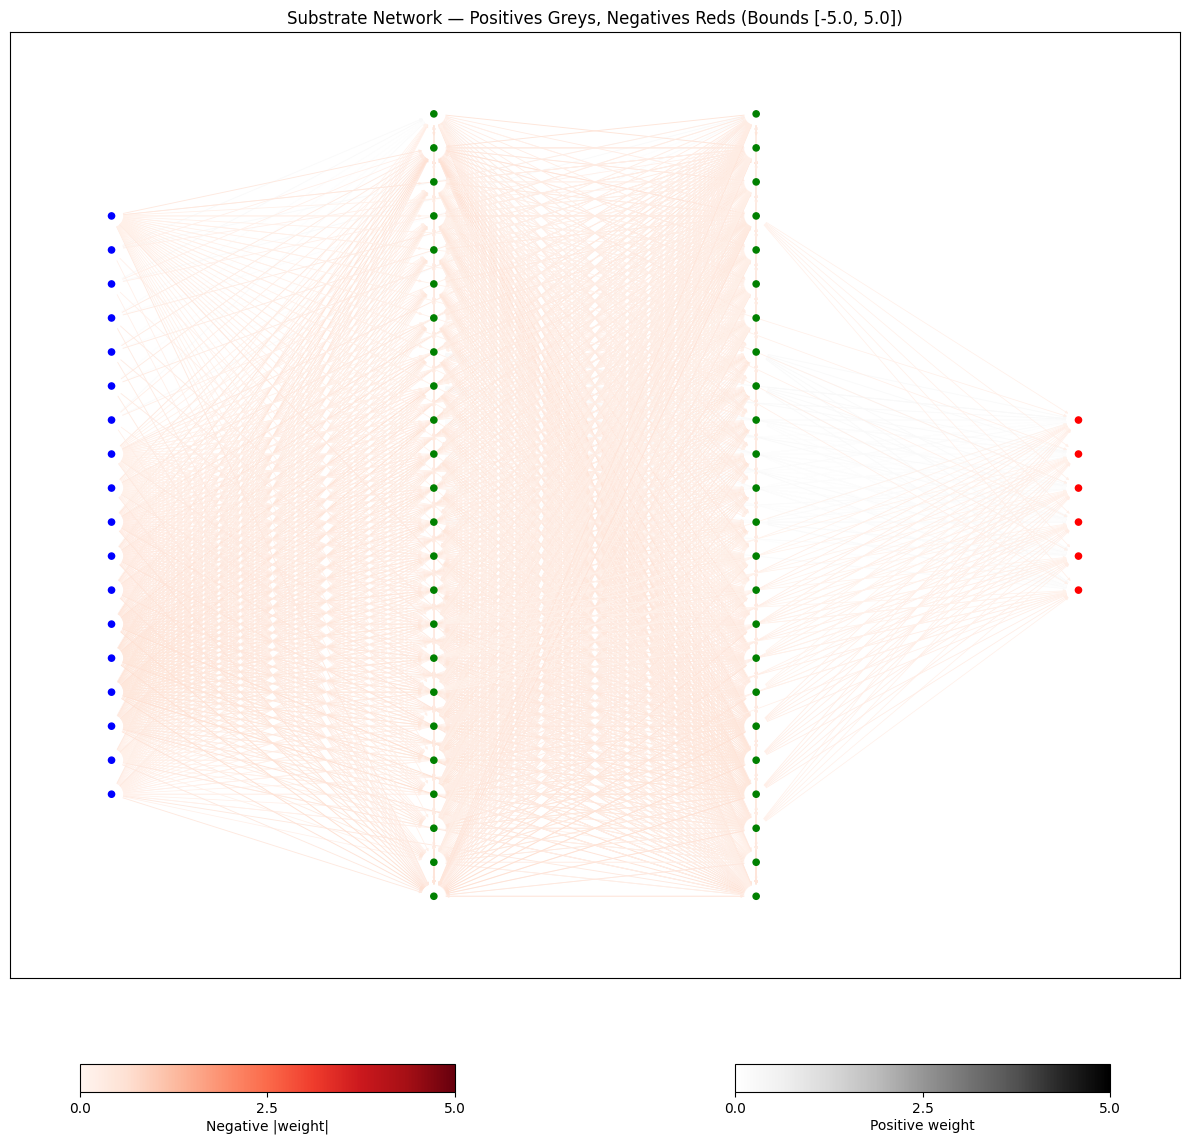

Visualization saved to: output/halfcheetah/topology/nn_manual_mapping.svg


initializing
initializing finished
start compile
compile finished, cost time: 33.180752s
Generation: 1, Cost time: 19043.30ms
 	fitness: valid cnt: 600, max: 1740.0677, min: -925.6922, mean: -206.8490, std: 440.2871

	node counts: max: 9, min: 7, mean: 8.08
 	conn counts: max: 9, min: 0, mean: 6.23
 	species: 15, [229, 28, 1, 6, 30, 2, 3, 29, 4, 59, 59, 7, 11, 1, 131]

Generation: 2, Cost time: 19023.65ms
 	fitness: valid cnt: 600, max: 1770.0303, min: -1068.9232, mean: 45.3289, std: 624.3462

	node counts: max: 10, min: 7, mean: 8.15
 	conn counts: max: 11, min: 0, mean: 5.70
 	species: 15, [25, 30, 20, 17, 81, 46, 20, 33, 11, 13, 30, 14, 3, 25, 232]

Generation: 3, Cost time: 19029.23ms
 	fitness: valid cnt: 600, max: 1776.5549, min: -953.9858, mean: 358.3545, std: 828.1767

	node counts: max: 11, min: 7, mean: 8.01
 	conn counts: max: 10, min: 0, mean: 5.08
 	species: 15, [21, 41, 34, 31, 33, 49, 47, 29, 14, 27, 79, 1, 32, 13, 149]

Generation: 4, Cost time: 19034.93ms
 	fitness: va

Total reward:  4718.465


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/halfcheetah/video/agent_trained_pca65.mp4
Visualizing CPPN. Saving to output/halfcheetah/topology/cppn_trained_pca65.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 2560 potential connections.
Visualizing 1287 connections. Excluded loops. Weight threshold: 0.1


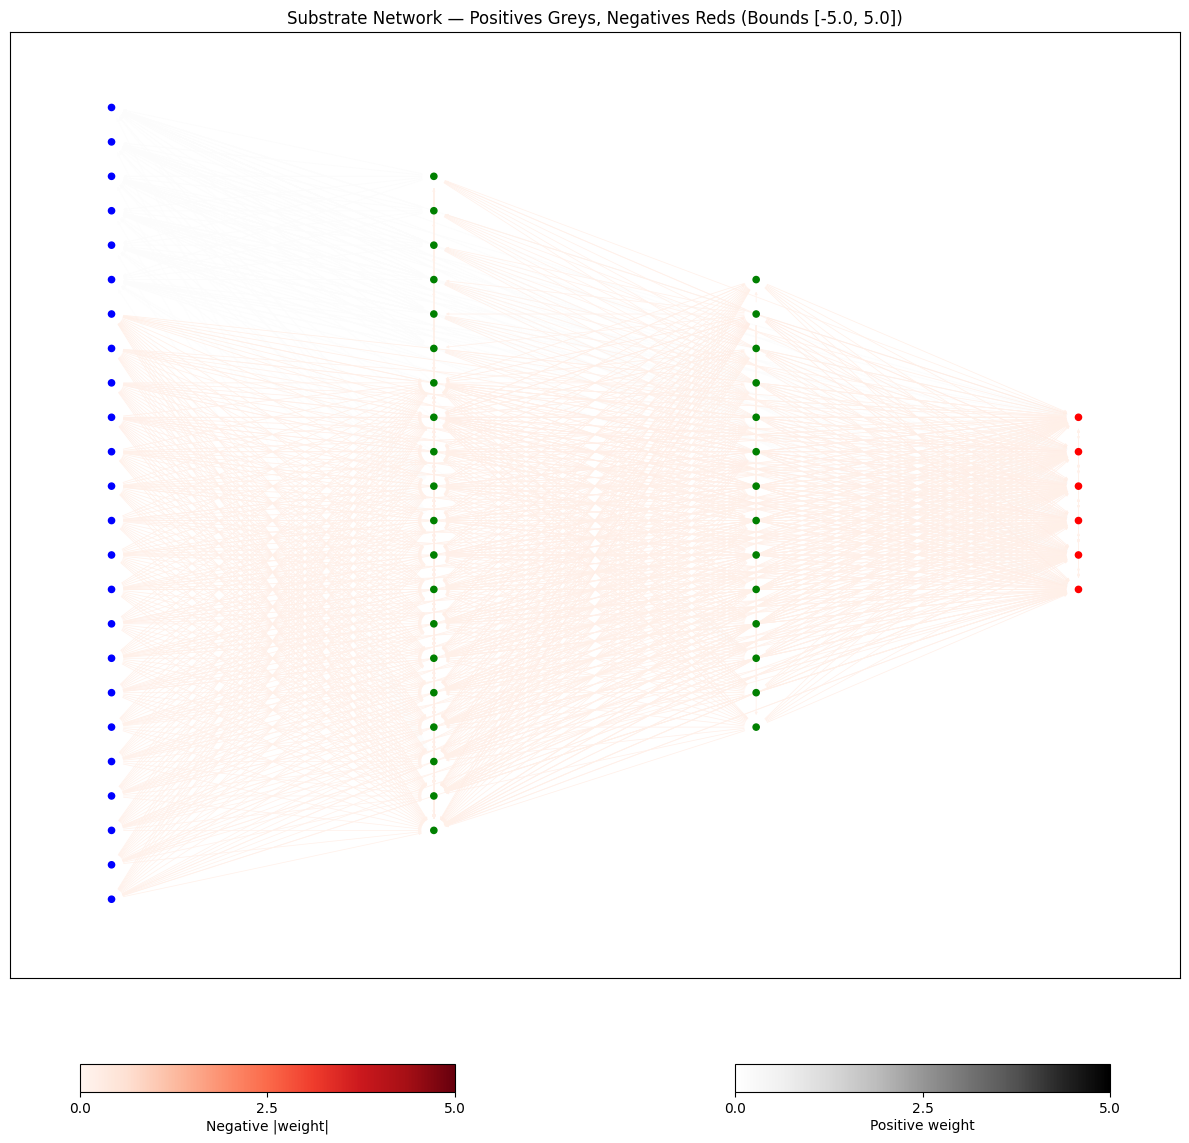

Visualization saved to: output/halfcheetah/topology/nn_trained_pca65.svg


initializing
initializing finished
start compile


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x734435c8dfc0>> (for post_run_cell), with arguments args (<ExecutionResult object at 733bebe1e380, execution_count=15 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 733bebe1e470, raw_cell="for data_label, data_dict in substrates.items():
 .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/andi/Dokumente/Bachelorarbeit/dim_tuning/main.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
for data_label, data_dict in substrates.items():
    for method_label, method_dict in data_dict.items():

        active_substrate = substrates[data_label][method_label]["substrate"]
        evol_algorithm = create_evol_algorithm(substrate=active_substrate)

        wanbd_name = f"{env_name}_{data_label}_{method_label}"
        wandb_tags = [config["substrate"]["hidden_layer_type"], env_name, data_label, method_label]

        wandb.init(
            name=wanbd_name,
            project="substrate_dims",
            tags=wandb_tags,
            config=config  
        )

        wandb.config.update({
            "substrate": {
                "obs_size": obs_size,
                "act_size": act_size,
                "substrate.query_coors.shape": active_substrate.query_coors.shape, # (num_queries, query_dim)
                "algorithm.num_inputs": evol_algorithm.num_inputs,
                }
            }
        )

        pipeline = CustomPipeline(
            algorithm=evol_algorithm,
            problem=env_problem,
            seed=config["experiment"]["seed"],
            generation_limit=config["evolution"]["generation_limit"],
            fitness_target=config["evolution"]["fitness_target"],
            is_save=False,
            save_dir=config["experiment"]["output_dir"],
        )

        init_state = pipeline.setup()
        state = pipeline.auto_run(state=init_state)

        print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

        wandb.finish()

        state_for_show = state[0] if isinstance(state, tuple) else state

        # Transform the best genome into network parameters
        best_genome = pipeline.best_genome

        # Built-in show method to produce and save a video of the agent
        pipeline.show(
            state=state_for_show,
            best=best_genome,
            output_type="mp4",
            save_path=f"{OUTPUT_DIR}/video/agent_{data_label}_{method_label}.mp4",
        )

        # All coordinates are needed for visualization
        input_coors = substrates[data_label][method_label]["input_coors"]
        hidden_coors = substrates[data_label][method_label]["hidden_coors"]
        output_coors = substrates[data_label][method_label]["output_coors"]

        # Visualizes the CPPN
        visualize_cppn(
            pipeline=pipeline, 
            state=state, 
            save_path=f"{OUTPUT_DIR}/topology/cppn_{data_label}_{method_label}.svg"
            )
        # Visualizes a representation of the neural network in 2D space
        visualize_nn(
            pipeline=pipeline, 
            state=state, 
            save_path=f"{OUTPUT_DIR}/topology/nn_{data_label}_{method_label}.svg", 
            substrate=active_substrate, 
            input_coors=input_coors, 
            hidden_coors=hidden_coors, 
            output_coors=output_coors, 
            hidden_depth=config["substrate"]["hidden_depth"], 
            weight_lower_limit=config["algorithm"]["conn_weight_lower_bound"], 
            weight_upper_limit=config["algorithm"]["conn_weight_upper_bound"]
            )
